## Reproduction of Figure 2 (Baseline Comparison)

This notebook reproduces the venn diagram in Figure 2.

In [1]:
import sys
sys.path.append("../../scripts/")
import json
import os 
import re
import glob
import pandas as pd
from collections import defaultdict
from evaluate_util import *

RESULT_PATH = '../../results/example2_n50.json'

project_name_map = {
    'Lang': 'Commons-lang',
    'Math': 'Commons-math',
    'Chart': 'JFreeChart',
    'Time': 'Joda-Time',
    'Mockito': 'Mockito'
}

target_projects = ['Time', 'Math', 'Lang', 'Chart', 'Mockito']

with open('../../data/Defects4J/invalid_bug_reports.txt') as f:
    invalid_bugs = [e.strip().replace('-', '_') for e in f.readlines()]

with open(RESULT_PATH) as f:
    data = json.load(f)

eval_df = process_results_for_baseline(data)
aggr_eval_df = eval_df.groupby('bug_id').sum().reset_index()
aggr_eval_df['project'] = aggr_eval_df.bug_id.apply(lambda x: x.split('_')[0])

succeeded_bugs = aggr_eval_df[aggr_eval_df.success > 0]
valid_bugs = aggr_eval_df[aggr_eval_df.buggy_version_failing > 0]
target_aggr_eval_df = aggr_eval_df[aggr_eval_df.project.isin(target_projects)]

libro_success_allprojects = set(succeeded_bugs.bug_id.tolist())

with open('../../data/Defects4J/jcrashpack_d4j_targets.txt', 'r') as f:
    jcrashpack_targets = [line.strip().replace('-', '_') for line in f.readlines() if line.strip() not in invalid_bugs]

targets = set(target_aggr_eval_df.bug_id.tolist()).union(jcrashpack_targets)

print('# of bugs in target projects (Lang, Math, Chart, Mockito. Time):', len(targets))
print('# of crash bugs in target projects:', len(jcrashpack_targets))

# of bugs in target projects (Lang, Math, Chart, Mockito. Time): 206
# of crash bugs in target projects: 60


### Load baseline result: Copy&Paste, EvoCrash
* EvoCrash result on JCrashPack: https://zenodo.org/record/3766686#.Yw7_-OxBxqs

In [3]:
with open('../../data/baseline/copy_n_paste_result.json') as f:
    copynpaste_success_allprojects = json.load(f)

evocrash_result = pd.read_csv('../../data/baseline/evocrash_result_df.csv')
botsing_result = pd.read_csv('../../data/baseline/botsing_result_df.csv')

In [33]:
evocrash_success = set([(bug_id[0] + bug_id[1:].lower()).replace('-', '_').removesuffix('b') for bug_id in evocrash_result[evocrash_result.fitness_function_value == 0].case.unique()])
botsing_success = set([(bug_id[0] + bug_id[1:].lower()).replace('-', '_').removesuffix('b') for bug_id in botsing_result[botsing_result.fitness_function_value == 0].case.unique()])

In [34]:
copynpaste_success = targets.intersection(copynpaste_success_allprojects)
evocrash_success = evocrash_success.intersection(targets)
botsing_success = botsing_success.intersection(targets)
libro_success = libro_success_allprojects.intersection(targets)
print(f'Reproduced Bugs by Ours: {len(libro_success)}')
# print(sorted(libro_success))

print(f'Reproduced Bugs by Evocrash: {len(evocrash_success)}')
# print(sorted(evocrash_success))

print(f'Reproduced Bugs by BotSing: {len(botsing_success)}')
# print(sorted(botsing_success))

Reproduced Bugs by Ours: 108
Reproduced Bugs by Evocrash: 47
Reproduced Bugs by BotSing: 47


### (1) All crashes

In [35]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted, venn3_unweighted

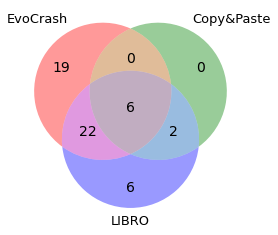

In [36]:
jcrashpack_targets = set(jcrashpack_targets)
out= venn3_unweighted([jcrashpack_targets.intersection(evocrash_success), jcrashpack_targets.intersection(copynpaste_success), jcrashpack_targets.intersection(libro_success)], ('EvoCrash', 'Copy&Paste', 'LIBRO'))
for text in out.set_labels:
    text.set_fontsize(13)
for text in out.subset_labels:
    text.set_fontsize(14)
plt.show()

### (2) With noncrashes 

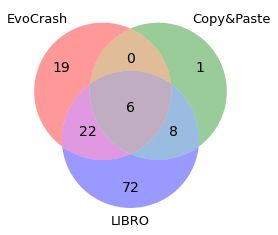

In [37]:
out = venn3_unweighted([set(evocrash_success), set(copynpaste_success), set(libro_success)], ('EvoCrash', 'Copy&Paste', 'LIBRO'))
for text in out.set_labels:
    text.set_fontsize(13)
for text in out.subset_labels:
    text.set_fontsize(14)

### (3) All Defects4J projects w/ bug reports

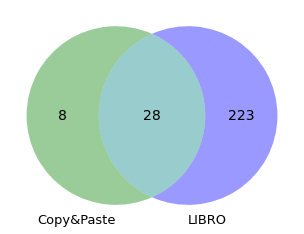

In [38]:
out = venn2_unweighted([set(copynpaste_success_allprojects), set(aggr_eval_df[aggr_eval_df.success > 0].bug_id.unique())], ('Copy&Paste', 'LIBRO'))
out.get_patch_by_id('10').set_color('green')
out.get_patch_by_id('01').set_color('blue')
out.get_patch_by_id('11').set_color('teal')
out.get_patch_by_id('11').set_alpha(0.4)
out.get_patch_by_id('10').set_edgecolor('none')
out.get_patch_by_id('01').set_edgecolor('none')
out.get_patch_by_id('11').set_edgecolor('none')

for text in out.set_labels:
    text.set_fontsize(13)
for text in out.subset_labels:
    text.set_fontsize(14)

plt.show()

### EvoCrash Two-version Evaluation

In [39]:
def file_prober(fname):
    with open(fname) as f:
        flines = f.readlines()
    
    look_for_exception = False
    exception_line = None
    for line in flines:
        if 'failure:' in line:
            look_for_exception = True
        if look_for_exception and re.match(r'.*: ', line) is not None:
            exception_line = line
            look_for_exception = False
    return exception_line

result_collater = defaultdict(lambda: ['', ''])
for fname in os.listdir('../data/baseline/evocrash_test_results'):
    tname = fname.split('.')[0]
    collater_idx = int('fixed' in fname)
    exception_line = file_prober('../data/baseline/evocrash_test_results/'+fname)
    result_collater[tname][collater_idx] = exception_line

In [40]:
reproducing = []
bugs_reproduced = []
total_bugs = []
for key in result_collater:
    buggy_exp, fixed_exp = result_collater[key]
    if buggy_exp != fixed_exp:
        reproducing.append(key)
        bugs_reproduced.append(key.split('#')[0])
    total_bugs.append(key.split('#')[0])
print('Reproduced:', set(bugs_reproduced), len(set(bugs_reproduced)))
print('All:', set(total_bugs), len(set(total_bugs)))

Reproduced: {'Math-89', 'Math-8', 'Math-4', 'Time-2', 'Lang-45', 'Lang-47', 'Lang-12', 'Lang-51', 'Math-61', 'Math-81', 'Math-97', 'Math-38', 'Math-95', 'Math-98', 'Math-1', 'Lang-33', 'Math-100', 'Math-84', 'Lang-19', 'Lang-27', 'Lang-9', 'Time-5', 'Math-90', 'Lang-39', 'Time-10', 'Math-32', 'Math-79', 'Math-70', 'Math-40'} 29
All: {'Math-89', 'Lang-1', 'Time-7', 'Math-8', 'Time-8', 'Math-4', 'Math-101', 'Math-60', 'Time-2', 'Lang-45', 'Lang-47', 'Lang-12', 'Lang-51', 'Lang-44', 'Lang-6', 'Math-61', 'Math-81', 'Mockito-9', 'Math-97', 'Time-14', 'Lang-36', 'Math-38', 'Math-95', 'Math-85', 'Time-18', 'Math-98', 'Math-1', 'Mockito-3', 'Math-31', 'Math-58', 'Lang-33', 'Mockito-7', 'Time-20', 'Mockito-10', 'Lang-16', 'Math-100', 'Math-84', 'Lang-19', 'Lang-35', 'Lang-27', 'Lang-9', 'Time-5', 'Math-78', 'Math-103', 'Math-90', 'Lang-57', 'Lang-39', 'Time-10', 'Math-49', 'Math-32', 'Math-70', 'Lang-54', 'Math-79', 'Math-40', 'Lang-5'} 55


In [46]:
print(jcrashpack_targets - set([b.replace('-', '_') for b in total_bugs]))

{'Lang_37', 'Lang_13', 'Math_3', 'Lang_20', 'Mockito_4'}


In [47]:
evocrash_success

{'Lang_1',
 'Lang_12',
 'Lang_16',
 'Lang_19',
 'Lang_27',
 'Lang_33',
 'Lang_35',
 'Lang_36',
 'Lang_39',
 'Lang_44',
 'Lang_45',
 'Lang_47',
 'Lang_5',
 'Lang_51',
 'Lang_54',
 'Lang_57',
 'Lang_6',
 'Lang_9',
 'Math_1',
 'Math_100',
 'Math_101',
 'Math_103',
 'Math_31',
 'Math_32',
 'Math_38',
 'Math_4',
 'Math_40',
 'Math_49',
 'Math_58',
 'Math_61',
 'Math_70',
 'Math_78',
 'Math_79',
 'Math_8',
 'Math_81',
 'Math_84',
 'Math_89',
 'Math_90',
 'Math_95',
 'Math_97',
 'Math_98',
 'Time_10',
 'Time_2',
 'Time_20',
 'Time_5',
 'Time_7',
 'Time_8'}

### [Appendix] Stack Trace Match Criteria on LIBRO

In [42]:
# Load stack traces 
buggy_outputs = {}

for bug_id in data:
    buggy_outputs[bug_id] = {}
    for file_name in data[bug_id]:
        if isinstance(data[bug_id][file_name], dict):
            output = data[bug_id][file_name]['buggy']['fib_error_msg']
            if output is None:
                continue 

            exception_type = output.split('\n')[1].split(':')[0].strip()
            stack_trace = output.split('\n')[2:]
            buggy_outputs[bug_id][file_name] = {
                # 'original_output': output,
                'exception_type': exception_type,
                'failure_msg': output.split('\n')[1],
                'stack_trace': stack_trace
            }

In [43]:
d4j_crash_outputs = defaultdict(dict)

for bug_id in targets:
    new_bug_id = bug_id.upper().replace('_', '-') + "b"
    original_crash_output = f'../data/baseline/jcrashpack/{project_name_map[bug_id.split("_")[0]]}/{new_bug_id}/{new_bug_id}.log'

    if not os.path.exists(original_crash_output):
        continue

    with open(original_crash_output) as f:
        lines = f.readlines()
    
    exception_type = lines[0].split(':')[0].strip()
    buggy_frames = lines[1:]
    d4j_crash_outputs[bug_id] = {
        'exception_type': exception_type,
        'failure_msg': lines[0].strip(),
        'buggy_frames': buggy_frames,
    }

In [44]:
def check_stack_trace_reproduced(buggy_frames, observed_stack_trace):
    buggy_frames = '\n'.join(buggy_frames)
    for frame in observed_stack_trace:
        if len(frame.strip()) == 0:
            continue
        exact_loc = frame.strip().split('(')[-1]
        if '.java:' not in exact_loc:
            continue

        if exact_loc in buggy_frames:
            return True 

    return False


buggy_output_reproduced_bug_ids = []
for bug_id in targets:
    for file_name, output in buggy_outputs[bug_id].items():
        if bug_id not in d4j_crash_outputs:
            continue
        original_output = d4j_crash_outputs[bug_id]
        if output['exception_type'].split('.')[-1] != original_output['exception_type'].split('.')[-1]:
                continue
            
        if check_stack_trace_reproduced(original_output['buggy_frames'], output['stack_trace']):
            buggy_output_reproduced_bug_ids.append({
                'bug_id': bug_id,
                'file_name': file_name,
                'exception_type': output['exception_type'],
                'stack_trace': output['stack_trace']
            })

df = pd.DataFrame(buggy_output_reproduced_bug_ids)

buggy_frame_match = df.bug_id.unique()
print(len(buggy_frame_match))



22
